In [1]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')


# Online Shopper Profiling via Clustering

This project uses clustering to identify discrete groups of online shoppers based on their shopping behavior. The dataset comes from the UC Irvine machine learning repository. The data can be downloaded [here](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset). The paper the data was used in has a tiny bit more detail on the data but not much. The paper dealt with training a neural net and they only cared about predictive accuracy so their explanation on the data that would help with a task like this is lacking. This is part of the challenge of the project.

There are 12330 user sessions recorded, each belonging to a different person and spread over a year. 
The variables are grouped into the following catagories
1. Number of page visits and duration in seconds on those page types for three page categories

    1. Administrative
    2. Administrative Duration
    3. Informational
    4. Informational Duration
    5. Product Related
    6. Product Related Duration
2. Google Analytics Outputs, Session Level Aggregated. Filling in some blanks to the explanation here

    7. Bounce Rate: the percent of pages the visitor visited and left without interaction. Based on comparing possible rationals with the actual value of bounce rates of some rows, I'm certain this is further weighted using the duration on pages or some other weighting. (For example, one visitor saw 25 pages, meaning their minimum bounce rate is 0.04, but the recorded bounce rate is 0.009)
    8. Exit Rate: Exit rate in general is the percent of people who leave the site on a page after interaction with it but the explanation doesn't translate well to session level. It could be something to do with the amount of pages someone clicked into, interacted with, then clicked out of back to the catalogue level. Think looking through an online clothes store, looking at a product by clicking around the pictures, then going back up to the catalogue level again. 
    9. Page Value: the average value of the pages visited before completing an e commerce transaction. Value is defined by being in the lineage leading up to a purchase I think. So higher value means they visited pages that are expected to be likely to get them to buy something.

For all these google analytics outputs, the explanation from the database contributors doesn't quite make sense fully to me but we'll take a look at the statistics of them during EDA and try to use them in clustering since they do seem to capture behavior that could be important.

3. Temporal

    10. Special Day: float from 0 to 1 that describes adjacency to a buying holiday such as valentine's day. The value is maximized 5 days before the holiday to account for shipping time and drops linearly to zero on the 5 days before and after that mark. So it starts at 0 ten days before, rises to one by the five days before mark, and drops back to zero by the holiday itself.
    11. Month: the month of the year the session was recorded
    12. Weekend: boolean to tell if it was a weekend

4. Demographic

    13. Operating System: number that captures the operating system of the visitor, has 8 distinct values so must also capture the version. The keys for these numbers aren't provided so I won't use this since it's not that useful.
    14. Browser: Same deal as OS, it's an integer and there's 13 distinct values, basically only 2 are used and the keys aren't provided so not using.
    15. Region: integer coded, 9 distinct values. Since we care more about behavior I'll throw this out since they didn't include keys again
    16. Traffic Type: in the paper this is briefly described as by what pipe did the customer arrive at the site and gives examples such as banner, sms, direct. There are 20 values and no key provided so I can't use this field either
    17. Visitor Type: only three types, new visitor, returning visitor, or other. Other makes up <<1% so I'll discard it and use the two others.

18. Revenue: class label saying if a transaction was made or not. I'll instead be using page value as a proxy for this. Page value is only non zero if there was a transaction and has more information encoded in it.

In [2]:
df = pd.read_csv('data/online_shoppers_intention.csv')

Drop the keys we said we wouldn't use and change the ordinal variables into numerical ones. Also Dropping the other visitor type since it's only 85 sessions.

In [3]:
drop_keys = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Revenue']
df.drop(columns = drop_keys, inplace=True)

In [4]:
vt_order = ['New_Visitor', 'Returning_Visitor', 'Other']
df['VisitorType'] = pd.Categorical(df['VisitorType'], categories=vt_order, ordered=True)
df['VisitorType'] = df['VisitorType'].cat.codes

df['Month'] = pd.Categorical(df['Month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)
df['Month'] = df['Month'].cat.codes

In [5]:
df = df[df['VisitorType'] != 2]

# Exploratory Data Analysis


The first thing we want to look at is the individual distributions of the variables. The most important takeaway from these is that we have a small number of extreme outliers that lie away from fairly normal looking data. We'll use RobustScalar for scaling later to make sure this doesn't hurt us. We also have some very standout months around holidays, standard for retail.

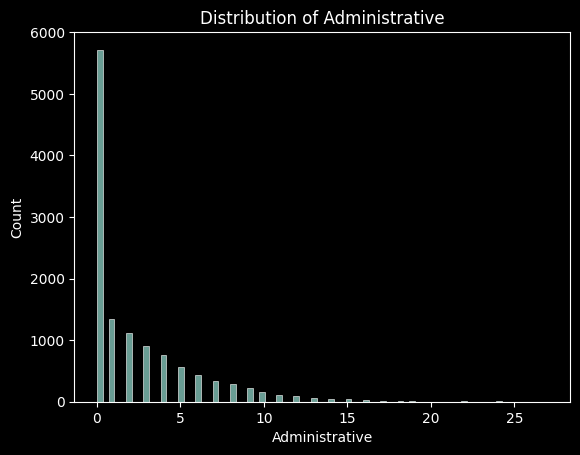

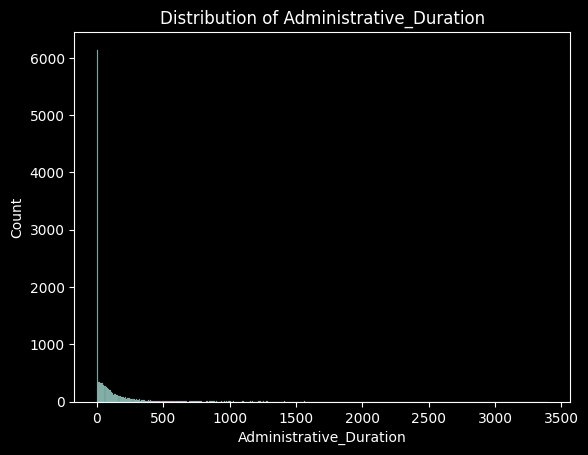

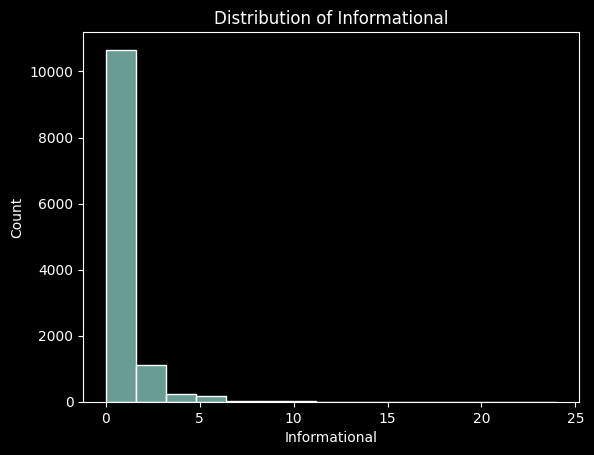

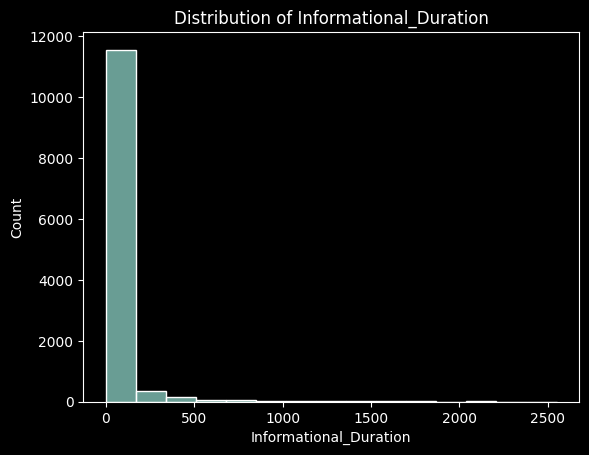

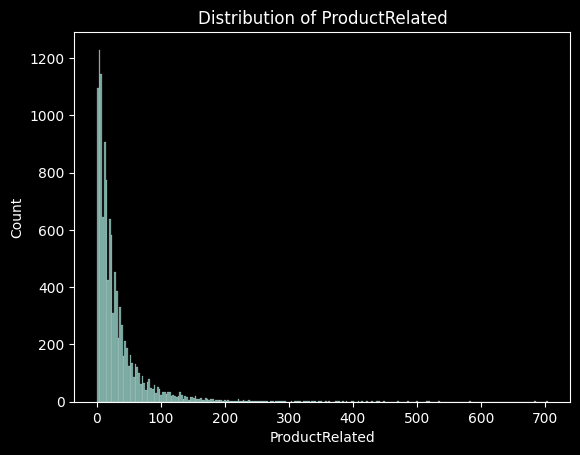

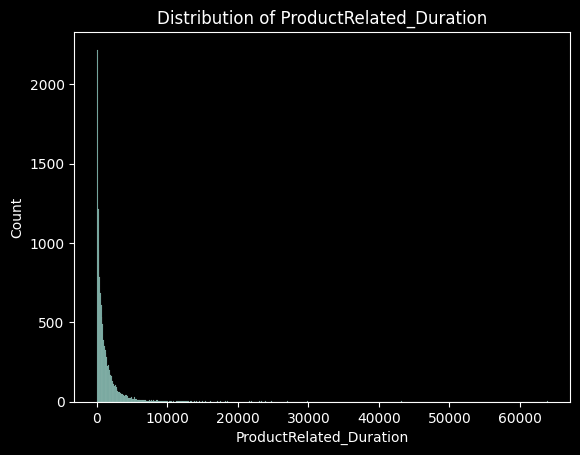

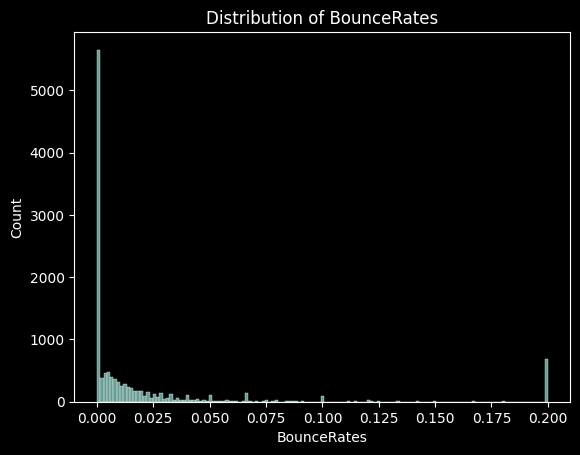

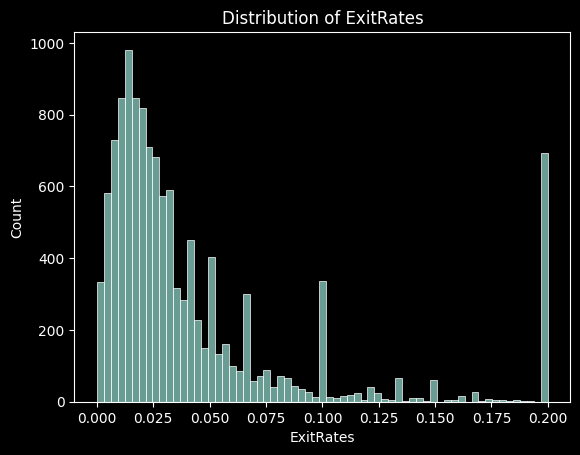

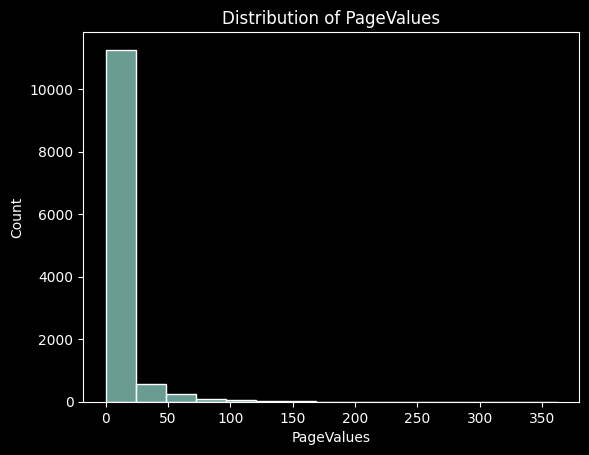

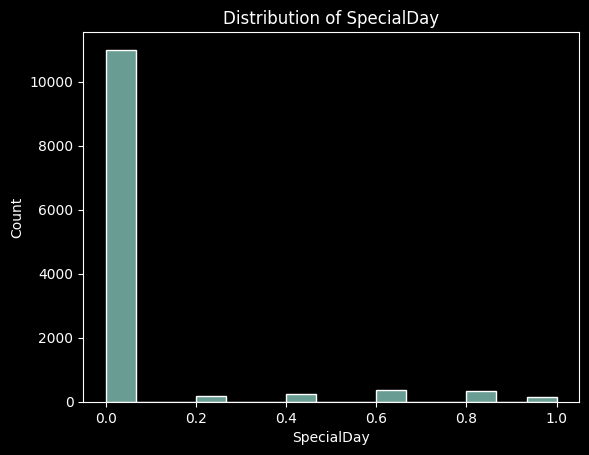

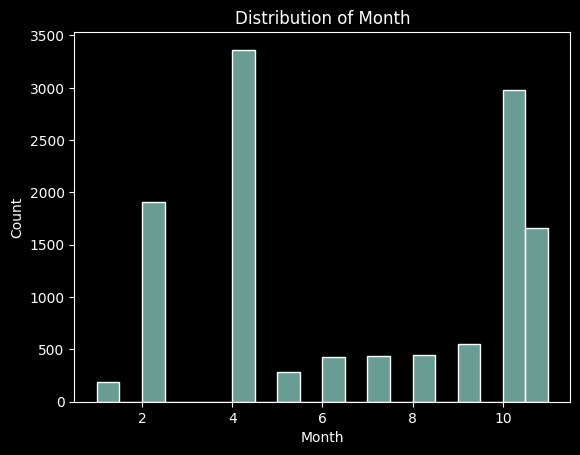

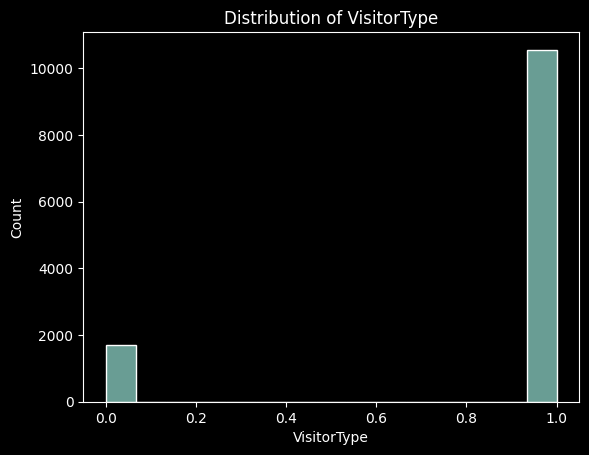

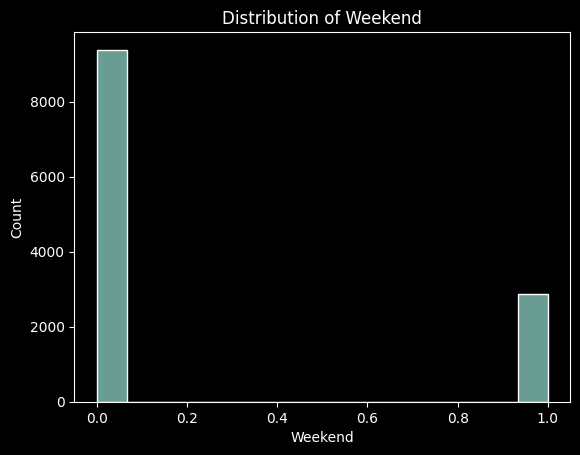

In [6]:
for col in df.columns:
    sns.histplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.show()

Now we check the pairplot.
1. The pages visited and time spent on those pages is remarkably not as correlated as I would've thought. It'll certainly be important to have both be part of the clustering. 

In [7]:
# sns.pairplot(df)

Now we're going to take a look at if and how we can use dimensionality reduction on our variables to make our clustering more accurate. We'll split the data into buy and not buy and then see if we can find any patterns deeper than that.

In [8]:
split = {"buy": df[df['PageValues'] > 0], "not_buy": df[df['PageValues'] == 0]}

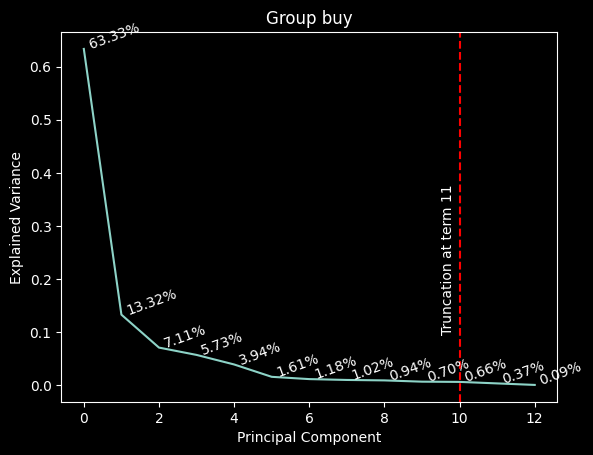

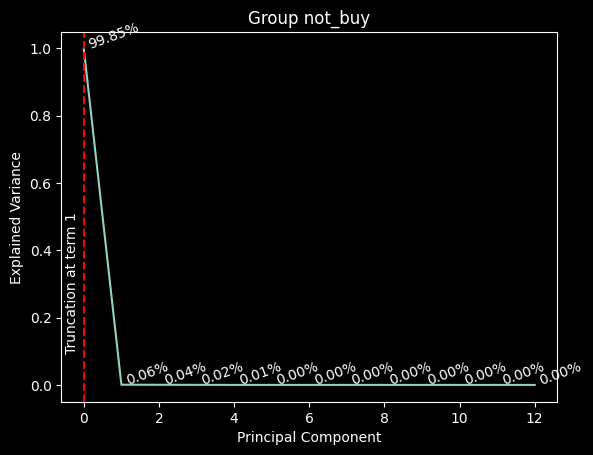

In [11]:
bnb_split = {"buy": df[df['PageValues'] >0], "not_buy": df[df['PageValues'] == 0]}
bnb_pca = {}

for key in bnb_split.keys():
    scalar = RobustScaler()
    bnb_split[key].loc[:, :] = scalar.fit_transform(bnb_split[key])
    pca = PCA()
    pca.fit_transform(bnb_split[key])
    bnb_pca[key] = pca
    plt.plot(pca.explained_variance_ratio_)
    plt.title(f'Group {key}')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    for pind, pca_var in enumerate(pca.explained_variance_ratio_):
        plt.text(pind+0.08, pca_var, f'{pca_var*100:0.2f}%', rotation = 20)

    trunc_term =np.where(np.cumsum(pca.explained_variance_ratio_)>=0.99)[0][0]
    plt.axvline(x=trunc_term, color='r', linestyle='--')

    plt.text(trunc_term-0.5, 0.1, f'Truncation at term {trunc_term+1}', rotation = 90)
    plt.show()

In [ ]:
buy_nbuy_split['buy'].keys()

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'VisitorType', 'Weekend'],
      dtype='object')

<Axes: >

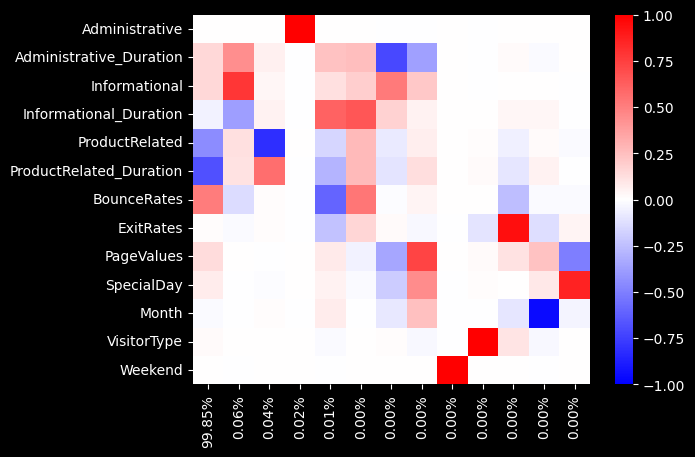

In [ ]:
sns.heatmap(bnb_pca['not_buy'].components_, 
            xticklabels=[f"{var*100:.2f}%" for var in bnb_pca['not_buy'].explained_variance_ratio_],
            yticklabels=buy_nbuy_split['not_buy'].keys(), cmap = 'bwr', vmax = 1, vmin = -1)

In [ ]:
doge = bnb_pca['not_buy'].transform(bnb_split['not_buy'])

<Axes: >

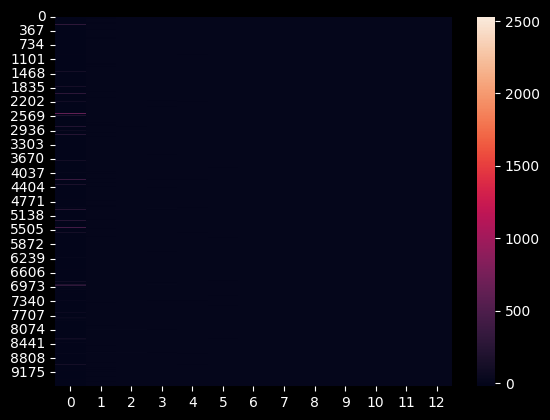

In [17]:
sns.heatmap(bnb_pca['not_buy'].transform(bnb_split['not_buy']))